In [2]:
!pip install transformers

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
#@title import packages

import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans

import torch.nn as nn

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize, Resize, Compose, ToPILImage

In [5]:
#@title Plotting functions

import argparse
import torch
import matplotlib.pyplot as plt
import torchvision.transforms
from torch import nn
from torchvision import transforms
import torch.nn.modules.utils as nn_utils
import math
#import timm
import types
from pathlib import Path
from typing import Union, List, Tuple
from PIL import Image
from matplotlib.colors import ListedColormap

def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    r"""Rescale and displays an image represented as a img.
    The function scales the img :attr:`im` to the [0 ,1] range.
    The img is assumed to have shape :math:`3\times H\times W` (RGB)
    :math:`1\times H\times W` (grayscale).
    Args:
        img (:class:`torch.Tensor` or :class:`PIL.Image`): image.
        quiet (bool, optional): if False, do not display image.
            Default: ``False``.
        lim (list, optional): maximum and minimum intensity value for
            rescaling. Default: ``None``.
        interpolation (str, optional): The interpolation mode to use with
            :func:`matplotlib.pyplot.imshow` (e.g. ``'lanczos'`` or
            ``'nearest'``). Default: ``'lanczos'``.
    Returns:
        :class:`torch.Tensor`: Rescaled image img.
    """
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                                *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap

def draw_correspondences(points1: List[Tuple[float, float]], points2: List[Tuple[float, float]],
                         image1: Image.Image, image2: Image.Image) -> Tuple[plt.Figure, plt.Figure]:
    """
    draw point correspondences on images.
    :param points1: a list of (y, x) coordinates of image1, corresponding to points2.
    :param points2: a list of (y, x) coordinates of image2, corresponding to points1.
    :param image1: a PIL image.
    :param image2: a PIL image.
    :return: two figures of images with marked points.
    """
    assert len(points1) == len(points2), f"points lengths are incompatible: {len(points1)} != {len(points2)}."
    num_points = len(points1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.axis('off')
    ax2.axis('off')
    #ax1.imshow(image1)
    #ax2.imshow(image2)
    ax1.imshow(imsc(image1))
    ax2.imshow(imsc(image2))

    if not points1:
      return fig

    if num_points > 15:
        cmap = plt.get_cmap('tab10')
    else:
        cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                               "maroon", "black", "white", "chocolate", "gray", "blueviolet"])
    colors = np.array([cmap(x) for x in range(num_points)])
    radius1, radius2 = 8, 1
    for point1, point2, color in zip(points1, points2, colors):
        y1, x1 = point1
        circ1_1 = plt.Circle((x1, y1), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x1, y1), radius2, facecolor=color, edgecolor='white')
        ax1.add_patch(circ1_1)
        ax1.add_patch(circ1_2)
        y2, x2 = point2
        circ2_1 = plt.Circle((x2, y2), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ2_2 = plt.Circle((x2, y2), radius2, facecolor=color, edgecolor='white')
        ax2.add_patch(circ2_1)
        ax2.add_patch(circ2_2)
    return fig

In [6]:
#@title create dataset

from transformers import AutoImageProcessor

#processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")
#processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
#processor = AutoProcessor.from_pretrained("facebook/vit-mae-large")
#processor = AutoProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
#processor.do_center_crop = False

target_mean = [0.485, 0.456, 0.406]
target_std = [0.229, 0.224, 0.225]
processor = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=target_mean, std=target_std)])

class CUB(Dataset):
    def __init__(self, base_path, train=True):

        self.base_path = base_path

        self.labels = pd.read_csv(''.join([base_path, 'image_class_labels.txt']), header=None, sep=" ", names=["id", "label"])
        self.train_test_split = pd.read_csv(''.join([base_path, 'train_test_split.txt']), header=None, sep=" ", names=["id", "is_train"])
        self.filenames = pd.read_csv(''.join([base_path, 'images.txt']), header=None, sep=" ")
        self.filenames = pd.read_csv(''.join([base_path, 'images.txt']), header=None, sep=" ")
        # self.segmentation_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/segmentations/'
        self.segmentation_path = '/mnt/d/Github/SuperpixelCUB/CUB_200_data/segmentations/' # change folder path on your local machine

        self.transforms = Compose([
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

        if train:
          mask = self.train_test_split.is_train.values == 1
        else:
          mask = self.train_test_split.is_train.values == 0

        self.filenames = self.filenames.iloc[mask]
        self.labels = self.labels[mask]

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):

        y = self.labels.iloc[index, 1] - 1
        file_name = self.filenames.iloc[index, 1]

        mask = np.array(Image.open(''.join([self.segmentation_path, file_name.split('.')[0], '.', file_name.split('.')[1], '.png'])).resize((224, 224)))

        x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
        x = processor(x)

        return x, y, (mask >= 1.0) * np.ones_like(mask)

[np.int64(34), np.int64(34), np.int64(174), np.int64(77)]


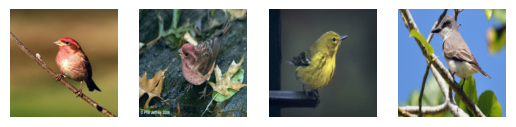

In [8]:
#@title dataset and dataloader and load samples

import random

query_transforms = Compose([
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomPerspective(distortion_scale=0.25, p=1.0),
        torchvision.transforms.RandomResizedCrop(size=224, scale=(0.5, 1.0)),
        ])

# base_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/'
base_path = '/mnt/d/Github/SuperpixelCUB/CUB_200_data/CUB_200_2011/' # change folder path on your local machine

train_dataset = CUB(base_path)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
#file_names, x, y = next(iter(train_loader))

NUMBER_OF_PROTOTYPES = 2

random.seed(501)
inputs, labels, masks = [], [], []
#data_indices = []
data_indices = random.sample(range(train_dataset.__len__()), NUMBER_OF_PROTOTYPES)
data_indices.insert(0, 1024)
data_indices.insert(0, 1028)
#data_indices.insert(0, 16)
#data_indices = [153, 151, 213, 244]

for counter, data_idx in enumerate(data_indices):

  x, y, mask = train_dataset.__getitem__(data_idx)

  #if counter == 0: x = query_transforms(x)

  inputs.append(x)
  labels.append(y)
  masks.append(mask)

print(labels)

plt.figure(1)
plt.subplot(141)
plt.imshow(imsc(inputs[0]))
plt.axis('off')
plt.subplot(142)
plt.imshow(imsc(inputs[1]))
plt.axis('off')
plt.subplot(143)
plt.imshow(imsc(inputs[2]))
plt.axis('off')
plt.subplot(144)
plt.imshow(imsc(inputs[3]))
plt.axis('off')
plt.show()


In [9]:
#@title load model


from transformers import AutoProcessor, CLIPVisionModel, Dinov2Model, ViTMAEModel, ViTModel

#model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14").to('cuda')
model = Dinov2Model.from_pretrained("facebook/dinov2-base").to('cuda')
#model = ViTMAEModel.from_pretrained("facebook/vit-mae-large", attn_implementation="eager").to('cuda')
#model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", attn_implementation="eager").to('cuda')


In [10]:
#@title create patch embeddings

IMG_SIZE = x.shape[-1]

device='cuda'

embedings = []
heatmaps = []

#embedings.append(model.encoder(model.get_input_embeddings()(input_i)).last_hidden_state[0, :, :].numpy(force=True)) MAE thing

with torch.no_grad():

    for counter, input_i in enumerate(inputs):

        input_i = input_i.to(device).unsqueeze(0)

        outputs = model(input_i, output_attentions=True)

        #embedings.append(model.visual_projection(outputs.last_hidden_state[0, 1:, :]).numpy(force=True))
        embedings.append(outputs.last_hidden_state[0, 1:, :].numpy(force=True))

        heatmaps.append(outputs.attentions[0].mean(1)[:, 0, 1:].numpy(force=True))

NUMBER_OF_PATCHES = outputs.last_hidden_state[0, 1:, :].shape[0]
SQRT_NUMBER_OF_PATCHES = int(np.sqrt(NUMBER_OF_PATCHES))
STRIDE = model.config.patch_size #model.get_submodule('embeddings').get_submodule('patch_embeddings').get_submodule('projection').stride[0]
PATCH_SIZE = model.config.patch_size
NUMBER_OF_PATCHES_X = NUMBER_OF_PATCHES_Y = int(IMG_SIZE / PATCH_SIZE)
LATENT_DIM = embedings[0].shape[-1]

Dinov2Model is using Dinov2SdpaSelfAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [12]:
from skimage.segmentation import slic, expand_labels
from skimage.transform import resize
from skimage.measure import regionprops

resize_size = 64
all_segments = []
all_keypoints = []

for embeding, mask in zip(embedings, masks):

    embeding = embeding.reshape(NUMBER_OF_PATCHES_X, NUMBER_OF_PATCHES_Y, -1)
    embeding = resize(embeding, (resize_size, resize_size))

    resized_mask = resize(mask, (resize_size, resize_size), order=0)
    #resized_mask = expand_labels(resized_mask, distance=4)

    segments = slic(embeding, n_segments=12, compactness=10.0, mask=resized_mask)
    all_segments.append(segments)

    low_res_keypoints = np.zeros_like(segments)
    props = regionprops(segments)

    for region_i, prop_i in enumerate(props):
        x_coordinate, y_coordinate = np.int32(np.round(prop_i.centroid))
        low_res_keypoints[x_coordinate, y_coordinate] = region_i+1

    keypoints = np.zeros((224, 224))

    high_res_keypoints = resize(low_res_keypoints, (224, 224), order=0)
    props = regionprops(high_res_keypoints)

    for region_i, prop_i in enumerate(props):
        x_coordinate, y_coordinate = np.int32(np.round(prop_i.centroid))
        keypoints[x_coordinate, y_coordinate] = region_i+1

    all_keypoints.append(np.int32(keypoints))


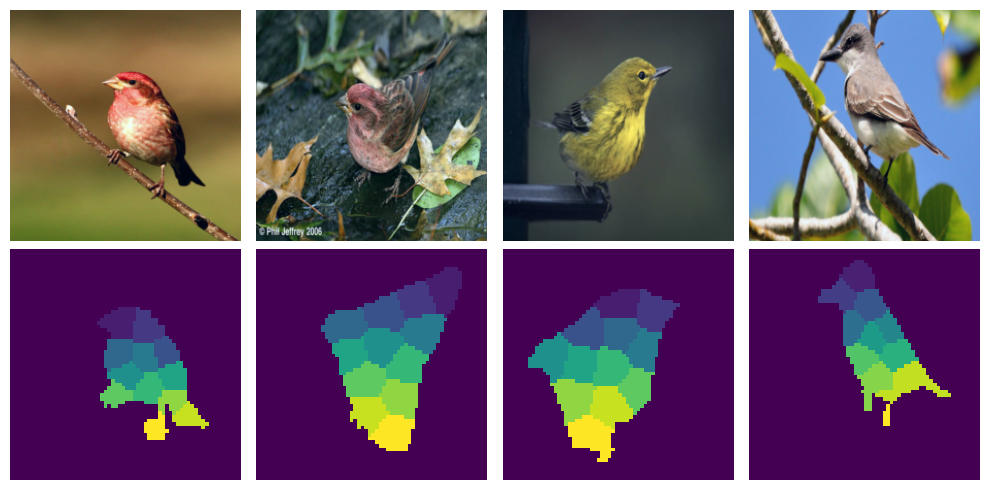

In [13]:

fig, axs = plt.subplots(2, NUMBER_OF_PROTOTYPES+2, figsize=(10, 5))

for col_idx, (image_i, segments_i) in enumerate(zip(inputs, all_segments)):

    axs[0, col_idx].imshow(imsc(image_i))
    axs[0, col_idx].set_axis_off()

    axs[1, col_idx].imshow(segments_i)
    axs[1, col_idx].set_axis_off()

fig.tight_layout()

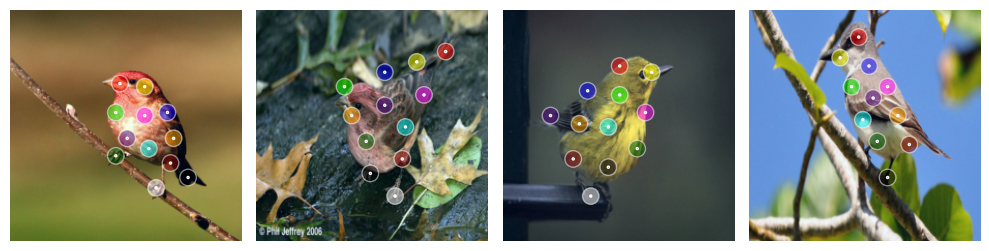

In [14]:

cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                    "maroon", "black", "white", "chocolate", "gray", "blueviolet"])

fig, axs = plt.subplots(1, NUMBER_OF_PROTOTYPES+2, figsize=(10, 5))

for col_idx, (image_i, keypoints_i) in enumerate(zip(inputs, all_keypoints)):

    axs[col_idx].imshow(imsc(image_i))
    axs[col_idx].set_axis_off()

    colors = np.array([cmap(x) for x in range(np.max(keypoints_i))])
    radius1, radius2 = 8, 1

    for keypoint_i, color in zip(np.unique(keypoints_i)[1:], colors):

        y_coordinate, x_coordinate = np.where(keypoints_i==keypoint_i)

        circ1_1 = plt.Circle((x_coordinate, y_coordinate), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x_coordinate, y_coordinate), radius2, facecolor=color, edgecolor='white')
        axs[col_idx].add_patch(circ1_1)
        axs[col_idx].add_patch(circ1_2)

fig.tight_layout()

In [15]:

number_of_query_regions = 0
number_of_prototype_regions = []
region_means = []

for sample_i, sample_i_segments in enumerate(all_segments):

    sample_i_region_means = []
    embeding = embedings[sample_i].reshape(NUMBER_OF_PATCHES_X, NUMBER_OF_PATCHES_Y, -1)
    embeding = resize(embeding, (resize_size, resize_size)).reshape(-1, LATENT_DIM)

    if sample_i == 0: number_of_query_regions = np.max(sample_i_segments)
    else: number_of_prototype_regions.append(np.max(sample_i_segments))

    for segment_i in np.unique(sample_i_segments)[1:]:

        segment_i_indices = np.where(sample_i_segments.flatten()==segment_i)[0]
        sample_i_region_means.append(np.mean(embeding[segment_i_indices], 0))

    region_means.append(sample_i_region_means)



In [16]:
query_region_means = np.array(region_means[0])

prototype_region_means = np.concatenate(region_means[1:])

nearest_neighbor_query, distances_query = pairwise_distances_argmin_min(query_region_means, prototype_region_means, axis=1, metric='cosine')
nearest_neighbor_prototypes, distances_prototype = pairwise_distances_argmin_min(query_region_means, prototype_region_means, axis=0, metric='cosine')

best_buddies_query = nearest_neighbor_prototypes[nearest_neighbor_query] == np.arange(number_of_query_regions)
best_buddies_prototypes = nearest_neighbor_query[nearest_neighbor_prototypes] == np.arange(np.sum(number_of_prototype_regions))

best_buddies_query_indices = nearest_neighbor_query[best_buddies_query]
best_buddies_prototypes_indices = nearest_neighbor_prototypes[best_buddies_prototypes]

print(best_buddies_query)
print(best_buddies_prototypes)

#best_buddies_query_indices = np.where(nearest_neighbor_prototypes[nearest_neighbor_query] == np.arange(number_of_query_regions))[0]
#best_buddies_prototypes_indices = np.where(nearest_neighbor_query[nearest_neighbor_prototypes] == np.arange(np.sum(number_of_prototype_regions)))[0]

[ True  True False False  True False  True  True  True  True  True  True]
[ True False False False False  True  True  True  True False False False
 False False False False False False False False False  True  True  True
 False False False False False False False False False False  True]


In [17]:
print(best_buddies_query_indices)
print(np.nonzero(best_buddies_query)[0])
print(np.arange(number_of_query_regions)[np.nonzero(best_buddies_query)[0]])
#np.arange(number_of_query_regions)[np.nonzero(best_buddies_query)[0]]

print(np.nonzero(best_buddies_prototypes)[0])
print(np.arange(np.sum(number_of_prototype_regions))[np.nonzero(best_buddies_prototypes)[0]])

[ 6  5  8  7 22 23 21  0 34]
[ 0  1  4  6  7  8  9 10 11]
[ 0  1  4  6  7  8  9 10 11]
[ 0  5  6  7  8 21 22 23 34]
[ 0  5  6  7  8 21 22 23 34]


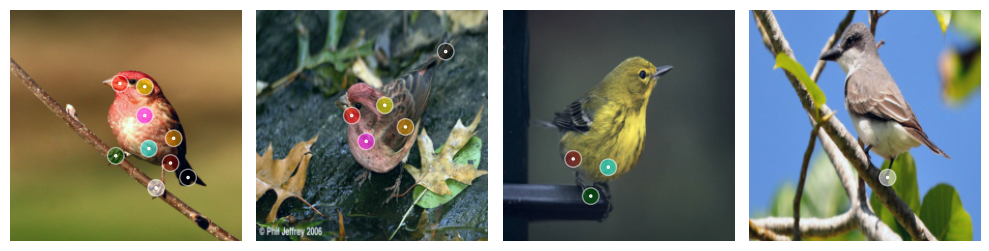

In [18]:

cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                    "maroon", "black", "white", "chocolate", "gray", "blueviolet"])

colors = np.array([cmap(x) for x in range(15)])

mnn_matches = {}

fig, axs = plt.subplots(1, NUMBER_OF_PROTOTYPES+2, figsize=(10, 5))

for col_idx, (image_i, keypoints_i) in enumerate(zip(inputs, all_keypoints)):

    #print('Sample', col_idx)
    #print(50*'-')

    axs[col_idx].imshow(imsc(image_i))
    axs[col_idx].set_axis_off()

    radius1, radius2 = 8, 1

    for keypoint_counter, keypoint_i in enumerate(np.unique(keypoints_i)[1:]):

        if col_idx == 0:
          if not best_buddies_query[keypoint_i-1]: continue
        elif col_idx == 1:
          if not best_buddies_prototypes[keypoint_i-1]: continue
        else:
          if not best_buddies_prototypes[np.sum(number_of_prototype_regions[:(col_idx-1)])+keypoint_i-1]: continue

        if col_idx == 0:
          color_value = keypoint_counter
          mnn_matches[keypoint_i-1] = color_value
        elif col_idx == 1:
          color_value = mnn_matches[nearest_neighbor_prototypes[keypoint_i-1]]
        else:
          color_value = mnn_matches[nearest_neighbor_prototypes[np.sum(number_of_prototype_regions[:(col_idx-1)])+keypoint_i-1]]

        y_coordinate, x_coordinate = np.where(keypoints_i==keypoint_i)

        circ1_1 = plt.Circle((x_coordinate, y_coordinate), radius1, facecolor=colors[color_value], edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x_coordinate, y_coordinate), radius2, facecolor=colors[color_value], edgecolor='white')
        axs[col_idx].add_patch(circ1_1)
        axs[col_idx].add_patch(circ1_2)


fig.tight_layout()